# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 1ms/sample - loss: 220.1387 - y1_output_loss: 106.5403 - y2_output_loss: 111.8491 - y1_output_root_mean_squared_error: 10.3642 - y2_output_root_mean_squared_error: 10.6171 - val_loss: 42.4678 - val_y1_output_loss: 18.8464 - val_y2_output_loss: 22.3902 - val_y1_output_root_mean_squared_error: 4.4141 - val_y2_output_root_mean_squared_error: 4.7941
Epoch 2/500
614/614 [==============================] - 0s 175us/sample - loss: 37.5740 - y1_output_loss: 13.2338 - y2_output_loss: 24.0102 - y1_output_root_mean_squared_error: 3.6534 - y2_output_root_mean_squared_error: 4.9220 - val_loss: 30.6388 - val_y1_output_loss: 13.0715 - val_y2_output_loss: 17.1192 - val_y1_output_root_mean_squared_error: 3.6578 - val_y2_output_root_mean_squared_error: 4.1545
Epoch 3/500
614/614 [==============================] - 0s 186us/sample - loss: 28.0735 - y1_output_loss: 10.8599 - y2_output_loss: 17.0536 - y1_o

614/614 [==============================] - 0s 167us/sample - loss: 12.8869 - y1_output_loss: 4.8389 - y2_output_loss: 7.9547 - y1_output_root_mean_squared_error: 2.2067 - y2_output_root_mean_squared_error: 2.8315 - val_loss: 11.3493 - val_y1_output_loss: 4.7232 - val_y2_output_loss: 6.3193 - val_y1_output_root_mean_squared_error: 2.2052 - val_y2_output_root_mean_squared_error: 2.5469
Epoch 22/500
614/614 [==============================] - 0s 174us/sample - loss: 11.8288 - y1_output_loss: 4.5585 - y2_output_loss: 7.3373 - y1_output_root_mean_squared_error: 2.1401 - y2_output_root_mean_squared_error: 2.6924 - val_loss: 14.2609 - val_y1_output_loss: 4.6342 - val_y2_output_loss: 9.1211 - val_y1_output_root_mean_squared_error: 2.1927 - val_y2_output_root_mean_squared_error: 3.0745
Epoch 23/500
614/614 [==============================] - 0s 168us/sample - loss: 14.1771 - y1_output_loss: 5.1057 - y2_output_loss: 8.9916 - y1_output_root_mean_squared_error: 2.2678 - y2_output_root_mean_squared_e

614/614 [==============================] - 0s 164us/sample - loss: 7.5644 - y1_output_loss: 2.3606 - y2_output_loss: 5.1719 - y1_output_root_mean_squared_error: 1.5438 - y2_output_root_mean_squared_error: 2.2762 - val_loss: 8.1353 - val_y1_output_loss: 2.4724 - val_y2_output_loss: 5.4338 - val_y1_output_root_mean_squared_error: 1.5931 - val_y2_output_root_mean_squared_error: 2.3659
Epoch 42/500
614/614 [==============================] - 0s 175us/sample - loss: 7.9616 - y1_output_loss: 2.5846 - y2_output_loss: 5.3660 - y1_output_root_mean_squared_error: 1.5985 - y2_output_root_mean_squared_error: 2.3252 - val_loss: 9.5064 - val_y1_output_loss: 3.1040 - val_y2_output_loss: 6.0592 - val_y1_output_root_mean_squared_error: 1.7945 - val_y2_output_root_mean_squared_error: 2.5073
Epoch 43/500
614/614 [==============================] - 0s 176us/sample - loss: 7.8411 - y1_output_loss: 2.4912 - y2_output_loss: 5.2976 - y1_output_root_mean_squared_error: 1.5814 - y2_output_root_mean_squared_error:

Epoch 62/500
614/614 [==============================] - 0s 162us/sample - loss: 5.7622 - y1_output_loss: 1.7378 - y2_output_loss: 4.0802 - y1_output_root_mean_squared_error: 1.3058 - y2_output_root_mean_squared_error: 2.0142 - val_loss: 7.3285 - val_y1_output_loss: 1.7129 - val_y2_output_loss: 5.3552 - val_y1_output_root_mean_squared_error: 1.3328 - val_y2_output_root_mean_squared_error: 2.3563
Epoch 63/500
614/614 [==============================] - 0s 165us/sample - loss: 7.5184 - y1_output_loss: 2.1032 - y2_output_loss: 5.4082 - y1_output_root_mean_squared_error: 1.4556 - y2_output_root_mean_squared_error: 2.3237 - val_loss: 6.3194 - val_y1_output_loss: 1.6590 - val_y2_output_loss: 4.4479 - val_y1_output_root_mean_squared_error: 1.3110 - val_y2_output_root_mean_squared_error: 2.1449
Epoch 64/500
614/614 [==============================] - 0s 174us/sample - loss: 7.7704 - y1_output_loss: 2.2491 - y2_output_loss: 5.5070 - y1_output_root_mean_squared_error: 1.4984 - y2_output_root_mean_s

Epoch 83/500
614/614 [==============================] - 0s 159us/sample - loss: 4.6287 - y1_output_loss: 1.3038 - y2_output_loss: 3.3191 - y1_output_root_mean_squared_error: 1.1464 - y2_output_root_mean_squared_error: 1.8206 - val_loss: 11.0186 - val_y1_output_loss: 1.9173 - val_y2_output_loss: 8.7777 - val_y1_output_root_mean_squared_error: 1.3995 - val_y2_output_root_mean_squared_error: 3.0100
Epoch 84/500
614/614 [==============================] - 0s 182us/sample - loss: 4.6667 - y1_output_loss: 1.3355 - y2_output_loss: 3.3140 - y1_output_root_mean_squared_error: 1.1532 - y2_output_root_mean_squared_error: 1.8267 - val_loss: 4.7206 - val_y1_output_loss: 1.0166 - val_y2_output_loss: 3.5956 - val_y1_output_root_mean_squared_error: 1.0204 - val_y2_output_root_mean_squared_error: 1.9182
Epoch 85/500
614/614 [==============================] - 0s 167us/sample - loss: 4.6847 - y1_output_loss: 1.3555 - y2_output_loss: 3.2909 - y1_output_root_mean_squared_error: 1.1697 - y2_output_root_mean_

Epoch 104/500
614/614 [==============================] - 0s 165us/sample - loss: 2.8110 - y1_output_loss: 0.7007 - y2_output_loss: 2.1210 - y1_output_root_mean_squared_error: 0.8398 - y2_output_root_mean_squared_error: 1.4511 - val_loss: 7.7325 - val_y1_output_loss: 1.4290 - val_y2_output_loss: 6.0677 - val_y1_output_root_mean_squared_error: 1.2134 - val_y2_output_root_mean_squared_error: 2.5021
Epoch 105/500
614/614 [==============================] - 0s 160us/sample - loss: 3.9843 - y1_output_loss: 1.1519 - y2_output_loss: 2.7966 - y1_output_root_mean_squared_error: 1.0777 - y2_output_root_mean_squared_error: 1.6801 - val_loss: 4.3821 - val_y1_output_loss: 0.7852 - val_y2_output_loss: 3.4620 - val_y1_output_root_mean_squared_error: 0.9007 - val_y2_output_root_mean_squared_error: 1.8897
Epoch 106/500
614/614 [==============================] - 0s 181us/sample - loss: 5.6256 - y1_output_loss: 1.5184 - y2_output_loss: 4.0699 - y1_output_root_mean_squared_error: 1.2374 - y2_output_root_mea

614/614 [==============================] - 0s 165us/sample - loss: 3.8727 - y1_output_loss: 0.8195 - y2_output_loss: 3.0300 - y1_output_root_mean_squared_error: 0.9083 - y2_output_root_mean_squared_error: 1.7458 - val_loss: 5.4071 - val_y1_output_loss: 1.2939 - val_y2_output_loss: 3.9436 - val_y1_output_root_mean_squared_error: 1.1558 - val_y2_output_root_mean_squared_error: 2.0177
Epoch 125/500
614/614 [==============================] - 0s 154us/sample - loss: 3.5224 - y1_output_loss: 0.9232 - y2_output_loss: 2.6321 - y1_output_root_mean_squared_error: 0.9619 - y2_output_root_mean_squared_error: 1.6116 - val_loss: 6.9011 - val_y1_output_loss: 0.9080 - val_y2_output_loss: 5.8044 - val_y1_output_root_mean_squared_error: 0.9662 - val_y2_output_root_mean_squared_error: 2.4428
Epoch 126/500
614/614 [==============================] - 0s 175us/sample - loss: 2.0888 - y1_output_loss: 0.4234 - y2_output_loss: 1.6610 - y1_output_root_mean_squared_error: 0.6528 - y2_output_root_mean_squared_erro

Epoch 145/500
614/614 [==============================] - 0s 180us/sample - loss: 1.8172 - y1_output_loss: 0.4250 - y2_output_loss: 1.3830 - y1_output_root_mean_squared_error: 0.6518 - y2_output_root_mean_squared_error: 1.1800 - val_loss: 3.0376 - val_y1_output_loss: 0.5201 - val_y2_output_loss: 2.4099 - val_y1_output_root_mean_squared_error: 0.7329 - val_y2_output_root_mean_squared_error: 1.5813
Epoch 146/500
614/614 [==============================] - 0s 162us/sample - loss: 1.8957 - y1_output_loss: 0.4744 - y2_output_loss: 1.4202 - y1_output_root_mean_squared_error: 0.6901 - y2_output_root_mean_squared_error: 1.1914 - val_loss: 2.4953 - val_y1_output_loss: 0.5544 - val_y2_output_loss: 1.8513 - val_y1_output_root_mean_squared_error: 0.7574 - val_y2_output_root_mean_squared_error: 1.3862
Epoch 147/500
614/614 [==============================] - 0s 158us/sample - loss: 1.7433 - y1_output_loss: 0.3384 - y2_output_loss: 1.3922 - y1_output_root_mean_squared_error: 0.5841 - y2_output_root_mea

614/614 [==============================] - ETA: 0s - loss: 2.1612 - y1_output_loss: 0.5631 - y2_output_loss: 1.5980 - y1_output_root_mean_squared_error: 0.7504 - y2_output_root_mean_squared_error: 1.2641  - 0s 173us/sample - loss: 2.0566 - y1_output_loss: 0.4885 - y2_output_loss: 1.5708 - y1_output_root_mean_squared_error: 0.6991 - y2_output_root_mean_squared_error: 1.2521 - val_loss: 4.1643 - val_y1_output_loss: 0.6186 - val_y2_output_loss: 3.4479 - val_y1_output_root_mean_squared_error: 0.7995 - val_y2_output_root_mean_squared_error: 1.8775
Epoch 166/500
614/614 [==============================] - 0s 167us/sample - loss: 2.3159 - y1_output_loss: 0.5578 - y2_output_loss: 1.7402 - y1_output_root_mean_squared_error: 0.7481 - y2_output_root_mean_squared_error: 1.3252 - val_loss: 1.8102 - val_y1_output_loss: 0.2380 - val_y2_output_loss: 1.5204 - val_y1_output_root_mean_squared_error: 0.4907 - val_y2_output_root_mean_squared_error: 1.2528
Epoch 167/500
614/614 [=============================

614/614 [==============================] - 0s 161us/sample - loss: 1.1137 - y1_output_loss: 0.2191 - y2_output_loss: 0.8923 - y1_output_root_mean_squared_error: 0.4698 - y2_output_root_mean_squared_error: 0.9449 - val_loss: 1.7358 - val_y1_output_loss: 0.2284 - val_y2_output_loss: 1.4509 - val_y1_output_root_mean_squared_error: 0.4846 - val_y2_output_root_mean_squared_error: 1.2251
Epoch 186/500
614/614 [==============================] - 0s 172us/sample - loss: 1.5040 - y1_output_loss: 0.3281 - y2_output_loss: 1.2164 - y1_output_root_mean_squared_error: 0.5733 - y2_output_root_mean_squared_error: 1.0841 - val_loss: 9.8708 - val_y1_output_loss: 0.6735 - val_y2_output_loss: 8.9455 - val_y1_output_root_mean_squared_error: 0.8322 - val_y2_output_root_mean_squared_error: 3.0296
Epoch 187/500
614/614 [==============================] - 0s 170us/sample - loss: 1.6336 - y1_output_loss: 0.3105 - y2_output_loss: 1.3136 - y1_output_root_mean_squared_error: 0.5590 - y2_output_root_mean_squared_erro

Epoch 206/500
614/614 [==============================] - 0s 155us/sample - loss: 1.7346 - y1_output_loss: 0.3878 - y2_output_loss: 1.3353 - y1_output_root_mean_squared_error: 0.6254 - y2_output_root_mean_squared_error: 1.1591 - val_loss: 1.9089 - val_y1_output_loss: 0.2517 - val_y2_output_loss: 1.5988 - val_y1_output_root_mean_squared_error: 0.5048 - val_y2_output_root_mean_squared_error: 1.2861
Epoch 207/500
614/614 [==============================] - 0s 184us/sample - loss: 1.8542 - y1_output_loss: 0.3376 - y2_output_loss: 1.5290 - y1_output_root_mean_squared_error: 0.5821 - y2_output_root_mean_squared_error: 1.2310 - val_loss: 6.5583 - val_y1_output_loss: 1.0113 - val_y2_output_loss: 5.3882 - val_y1_output_root_mean_squared_error: 1.0185 - val_y2_output_root_mean_squared_error: 2.3497
Epoch 208/500
614/614 [==============================] - 0s 173us/sample - loss: 2.1120 - y1_output_loss: 0.5058 - y2_output_loss: 1.5941 - y1_output_root_mean_squared_error: 0.7101 - y2_output_root_mea

614/614 [==============================] - 0s 167us/sample - loss: 0.9381 - y1_output_loss: 0.1984 - y2_output_loss: 0.7367 - y1_output_root_mean_squared_error: 0.4471 - y2_output_root_mean_squared_error: 0.8592 - val_loss: 1.5864 - val_y1_output_loss: 0.2122 - val_y2_output_loss: 1.3326 - val_y1_output_root_mean_squared_error: 0.4640 - val_y2_output_root_mean_squared_error: 1.1709
Epoch 227/500
614/614 [==============================] - 0s 170us/sample - loss: 1.2887 - y1_output_loss: 0.2858 - y2_output_loss: 1.0013 - y1_output_root_mean_squared_error: 0.5353 - y2_output_root_mean_squared_error: 1.0011 - val_loss: 3.2084 - val_y1_output_loss: 0.8640 - val_y2_output_loss: 2.2602 - val_y1_output_root_mean_squared_error: 0.9442 - val_y2_output_root_mean_squared_error: 1.5221
Epoch 228/500
614/614 [==============================] - 0s 181us/sample - loss: 1.2982 - y1_output_loss: 0.3028 - y2_output_loss: 0.9908 - y1_output_root_mean_squared_error: 0.5468 - y2_output_root_mean_squared_erro

Epoch 247/500
614/614 [==============================] - 0s 154us/sample - loss: 0.9865 - y1_output_loss: 0.2212 - y2_output_loss: 0.7629 - y1_output_root_mean_squared_error: 0.4696 - y2_output_root_mean_squared_error: 0.8752 - val_loss: 1.5448 - val_y1_output_loss: 0.1910 - val_y2_output_loss: 1.3082 - val_y1_output_root_mean_squared_error: 0.4418 - val_y2_output_root_mean_squared_error: 1.1617
Epoch 248/500
614/614 [==============================] - 0s 181us/sample - loss: 2.0254 - y1_output_loss: 0.5639 - y2_output_loss: 1.4802 - y1_output_root_mean_squared_error: 0.7514 - y2_output_root_mean_squared_error: 1.2086 - val_loss: 8.6484 - val_y1_output_loss: 3.7566 - val_y2_output_loss: 4.6550 - val_y1_output_root_mean_squared_error: 1.9697 - val_y2_output_root_mean_squared_error: 2.1837
Epoch 249/500
614/614 [==============================] - 0s 192us/sample - loss: 4.5953 - y1_output_loss: 1.2859 - y2_output_loss: 3.2780 - y1_output_root_mean_squared_error: 1.1393 - y2_output_root_mea

614/614 [==============================] - 0s 155us/sample - loss: 0.7877 - y1_output_loss: 0.1623 - y2_output_loss: 0.6210 - y1_output_root_mean_squared_error: 0.4018 - y2_output_root_mean_squared_error: 0.7913 - val_loss: 1.2666 - val_y1_output_loss: 0.1655 - val_y2_output_loss: 1.0640 - val_y1_output_root_mean_squared_error: 0.4119 - val_y2_output_root_mean_squared_error: 1.0474
Epoch 268/500
614/614 [==============================] - 0s 161us/sample - loss: 1.4187 - y1_output_loss: 0.3325 - y2_output_loss: 1.1391 - y1_output_root_mean_squared_error: 0.5608 - y2_output_root_mean_squared_error: 1.0508 - val_loss: 13.8942 - val_y1_output_loss: 2.9521 - val_y2_output_loss: 10.6049 - val_y1_output_root_mean_squared_error: 1.7404 - val_y2_output_root_mean_squared_error: 3.2962
Epoch 269/500
614/614 [==============================] - 0s 180us/sample - loss: 1.7175 - y1_output_loss: 0.3598 - y2_output_loss: 1.3441 - y1_output_root_mean_squared_error: 0.6027 - y2_output_root_mean_squared_er

Epoch 288/500
614/614 [==============================] - 0s 168us/sample - loss: 0.7801 - y1_output_loss: 0.1556 - y2_output_loss: 0.6658 - y1_output_root_mean_squared_error: 0.3945 - y2_output_root_mean_squared_error: 0.7902 - val_loss: 11.1896 - val_y1_output_loss: 1.1996 - val_y2_output_loss: 9.7367 - val_y1_output_root_mean_squared_error: 1.1092 - val_y2_output_root_mean_squared_error: 3.1558
Epoch 289/500
614/614 [==============================] - 0s 161us/sample - loss: 1.0809 - y1_output_loss: 0.2078 - y2_output_loss: 0.9098 - y1_output_root_mean_squared_error: 0.4548 - y2_output_root_mean_squared_error: 0.9349 - val_loss: 2.7966 - val_y1_output_loss: 0.2796 - val_y2_output_loss: 2.4836 - val_y1_output_root_mean_squared_error: 0.5373 - val_y2_output_root_mean_squared_error: 1.5836
Epoch 290/500
614/614 [==============================] - 0s 179us/sample - loss: 0.8782 - y1_output_loss: 0.2025 - y2_output_loss: 0.6695 - y1_output_root_mean_squared_error: 0.4517 - y2_output_root_me

614/614 [==============================] - 0s 171us/sample - loss: 0.5899 - y1_output_loss: 0.1545 - y2_output_loss: 0.4364 - y1_output_root_mean_squared_error: 0.3939 - y2_output_root_mean_squared_error: 0.6593 - val_loss: 1.2423 - val_y1_output_loss: 0.2094 - val_y2_output_loss: 0.9913 - val_y1_output_root_mean_squared_error: 0.4631 - val_y2_output_root_mean_squared_error: 1.0138
Epoch 309/500
614/614 [==============================] - 0s 157us/sample - loss: 0.6554 - y1_output_loss: 0.1693 - y2_output_loss: 0.4922 - y1_output_root_mean_squared_error: 0.4118 - y2_output_root_mean_squared_error: 0.6970 - val_loss: 2.5679 - val_y1_output_loss: 0.2053 - val_y2_output_loss: 2.2758 - val_y1_output_root_mean_squared_error: 0.4607 - val_y2_output_root_mean_squared_error: 1.5348
Epoch 310/500
614/614 [==============================] - 0s 158us/sample - loss: 0.7706 - y1_output_loss: 0.1741 - y2_output_loss: 0.5921 - y1_output_root_mean_squared_error: 0.4185 - y2_output_root_mean_squared_erro

Epoch 329/500
614/614 [==============================] - 0s 168us/sample - loss: 1.0514 - y1_output_loss: 0.2200 - y2_output_loss: 0.8254 - y1_output_root_mean_squared_error: 0.4702 - y2_output_root_mean_squared_error: 0.9112 - val_loss: 1.0474 - val_y1_output_loss: 0.2023 - val_y2_output_loss: 0.8194 - val_y1_output_root_mean_squared_error: 0.4551 - val_y2_output_root_mean_squared_error: 0.9167
Epoch 330/500
614/614 [==============================] - 0s 158us/sample - loss: 0.5109 - y1_output_loss: 0.1398 - y2_output_loss: 0.3756 - y1_output_root_mean_squared_error: 0.3718 - y2_output_root_mean_squared_error: 0.6105 - val_loss: 1.6783 - val_y1_output_loss: 0.1971 - val_y2_output_loss: 1.4622 - val_y1_output_root_mean_squared_error: 0.4493 - val_y2_output_root_mean_squared_error: 1.2151
Epoch 331/500
614/614 [==============================] - 0s 157us/sample - loss: 0.6583 - y1_output_loss: 0.1440 - y2_output_loss: 0.5112 - y1_output_root_mean_squared_error: 0.3803 - y2_output_root_mea

614/614 [==============================] - 0s 172us/sample - loss: 0.6192 - y1_output_loss: 0.1665 - y2_output_loss: 0.4832 - y1_output_root_mean_squared_error: 0.4066 - y2_output_root_mean_squared_error: 0.6737 - val_loss: 9.7531 - val_y1_output_loss: 1.2427 - val_y2_output_loss: 8.3101 - val_y1_output_root_mean_squared_error: 1.1237 - val_y2_output_root_mean_squared_error: 2.9138
Epoch 350/500
614/614 [==============================] - 0s 161us/sample - loss: 0.8890 - y1_output_loss: 0.2379 - y2_output_loss: 0.6451 - y1_output_root_mean_squared_error: 0.4885 - y2_output_root_mean_squared_error: 0.8064 - val_loss: 1.3490 - val_y1_output_loss: 0.1798 - val_y2_output_loss: 1.1246 - val_y1_output_root_mean_squared_error: 0.4278 - val_y2_output_root_mean_squared_error: 1.0798
Epoch 351/500
614/614 [==============================] - 0s 158us/sample - loss: 0.9051 - y1_output_loss: 0.2230 - y2_output_loss: 0.6758 - y1_output_root_mean_squared_error: 0.4744 - y2_output_root_mean_squared_erro

Epoch 370/500
614/614 [==============================] - 0s 146us/sample - loss: 0.4572 - y1_output_loss: 0.1316 - y2_output_loss: 0.3228 - y1_output_root_mean_squared_error: 0.3638 - y2_output_root_mean_squared_error: 0.5700 - val_loss: 1.2379 - val_y1_output_loss: 0.2946 - val_y2_output_loss: 0.9070 - val_y1_output_root_mean_squared_error: 0.5514 - val_y2_output_root_mean_squared_error: 0.9664
Epoch 371/500
614/614 [==============================] - 0s 163us/sample - loss: 0.8202 - y1_output_loss: 0.2207 - y2_output_loss: 0.5941 - y1_output_root_mean_squared_error: 0.4703 - y2_output_root_mean_squared_error: 0.7739 - val_loss: 1.6028 - val_y1_output_loss: 0.2706 - val_y2_output_loss: 1.2842 - val_y1_output_root_mean_squared_error: 0.5252 - val_y2_output_root_mean_squared_error: 1.1519
Epoch 372/500
614/614 [==============================] - 0s 157us/sample - loss: 0.5211 - y1_output_loss: 0.1327 - y2_output_loss: 0.3927 - y1_output_root_mean_squared_error: 0.3637 - y2_output_root_mea

614/614 [==============================] - 0s 170us/sample - loss: 0.6180 - y1_output_loss: 0.1522 - y2_output_loss: 0.4643 - y1_output_root_mean_squared_error: 0.3910 - y2_output_root_mean_squared_error: 0.6820 - val_loss: 1.4041 - val_y1_output_loss: 0.1994 - val_y2_output_loss: 1.1589 - val_y1_output_root_mean_squared_error: 0.4514 - val_y2_output_root_mean_squared_error: 1.0956
Epoch 391/500
614/614 [==============================] - 0s 157us/sample - loss: 0.7531 - y1_output_loss: 0.1737 - y2_output_loss: 0.5917 - y1_output_root_mean_squared_error: 0.4096 - y2_output_root_mean_squared_error: 0.7651 - val_loss: 1.3757 - val_y1_output_loss: 0.2683 - val_y2_output_loss: 1.0763 - val_y1_output_root_mean_squared_error: 0.5266 - val_y2_output_root_mean_squared_error: 1.0481
Epoch 392/500
614/614 [==============================] - 0s 159us/sample - loss: 0.5388 - y1_output_loss: 0.1398 - y2_output_loss: 0.3969 - y1_output_root_mean_squared_error: 0.3742 - y2_output_root_mean_squared_erro

Epoch 411/500
614/614 [==============================] - 0s 155us/sample - loss: 0.5034 - y1_output_loss: 0.1345 - y2_output_loss: 0.3693 - y1_output_root_mean_squared_error: 0.3677 - y2_output_root_mean_squared_error: 0.6068 - val_loss: 1.1191 - val_y1_output_loss: 0.1797 - val_y2_output_loss: 0.9014 - val_y1_output_root_mean_squared_error: 0.4299 - val_y2_output_root_mean_squared_error: 0.9665
Epoch 412/500
614/614 [==============================] - 0s 161us/sample - loss: 0.6274 - y1_output_loss: 0.1603 - y2_output_loss: 0.4679 - y1_output_root_mean_squared_error: 0.3975 - y2_output_root_mean_squared_error: 0.6851 - val_loss: 1.2474 - val_y1_output_loss: 0.3305 - val_y2_output_loss: 0.8790 - val_y1_output_root_mean_squared_error: 0.5815 - val_y2_output_root_mean_squared_error: 0.9536
Epoch 413/500
614/614 [==============================] - 0s 157us/sample - loss: 0.5400 - y1_output_loss: 0.1739 - y2_output_loss: 0.3617 - y1_output_root_mean_squared_error: 0.4189 - y2_output_root_mea

614/614 [==============================] - 0s 144us/sample - loss: 0.7066 - y1_output_loss: 0.1704 - y2_output_loss: 0.5957 - y1_output_root_mean_squared_error: 0.4033 - y2_output_root_mean_squared_error: 0.7375 - val_loss: 2.4408 - val_y1_output_loss: 0.2385 - val_y2_output_loss: 2.1738 - val_y1_output_root_mean_squared_error: 0.4940 - val_y2_output_root_mean_squared_error: 1.4821
Epoch 432/500
614/614 [==============================] - 0s 148us/sample - loss: 0.5169 - y1_output_loss: 0.1512 - y2_output_loss: 0.3637 - y1_output_root_mean_squared_error: 0.3896 - y2_output_root_mean_squared_error: 0.6042 - val_loss: 0.8381 - val_y1_output_loss: 0.1498 - val_y2_output_loss: 0.6603 - val_y1_output_root_mean_squared_error: 0.3925 - val_y2_output_root_mean_squared_error: 0.8271
Epoch 433/500
614/614 [==============================] - 0s 161us/sample - loss: 0.5254 - y1_output_loss: 0.1226 - y2_output_loss: 0.3998 - y1_output_root_mean_squared_error: 0.3514 - y2_output_root_mean_squared_erro

Epoch 452/500
614/614 [==============================] - 0s 152us/sample - loss: 0.5170 - y1_output_loss: 0.1382 - y2_output_loss: 0.3750 - y1_output_root_mean_squared_error: 0.3722 - y2_output_root_mean_squared_error: 0.6152 - val_loss: 1.0503 - val_y1_output_loss: 0.2508 - val_y2_output_loss: 0.7634 - val_y1_output_root_mean_squared_error: 0.5082 - val_y2_output_root_mean_squared_error: 0.8900
Epoch 453/500
614/614 [==============================] - 0s 148us/sample - loss: 0.3578 - y1_output_loss: 0.1195 - y2_output_loss: 0.2370 - y1_output_root_mean_squared_error: 0.3460 - y2_output_root_mean_squared_error: 0.4879 - val_loss: 0.9284 - val_y1_output_loss: 0.1624 - val_y2_output_loss: 0.7356 - val_y1_output_root_mean_squared_error: 0.4079 - val_y2_output_root_mean_squared_error: 0.8729
Epoch 454/500
614/614 [==============================] - 0s 153us/sample - loss: 0.4194 - y1_output_loss: 0.1323 - y2_output_loss: 0.2860 - y1_output_root_mean_squared_error: 0.3650 - y2_output_root_mea

614/614 [==============================] - 0s 176us/sample - loss: 0.5311 - y1_output_loss: 0.1383 - y2_output_loss: 0.3995 - y1_output_root_mean_squared_error: 0.3682 - y2_output_root_mean_squared_error: 0.6289 - val_loss: 1.6459 - val_y1_output_loss: 0.3258 - val_y2_output_loss: 1.2961 - val_y1_output_root_mean_squared_error: 0.5752 - val_y2_output_root_mean_squared_error: 1.1468
Epoch 473/500
614/614 [==============================] - 0s 166us/sample - loss: 0.3604 - y1_output_loss: 0.1164 - y2_output_loss: 0.2418 - y1_output_root_mean_squared_error: 0.3421 - y2_output_root_mean_squared_error: 0.4933 - val_loss: 0.8313 - val_y1_output_loss: 0.1600 - val_y2_output_loss: 0.6496 - val_y1_output_root_mean_squared_error: 0.4059 - val_y2_output_root_mean_squared_error: 0.8164
Epoch 474/500
614/614 [==============================] - 0s 190us/sample - loss: 0.3445 - y1_output_loss: 0.1103 - y2_output_loss: 0.2347 - y1_output_root_mean_squared_error: 0.3322 - y2_output_root_mean_squared_erro

Epoch 493/500
614/614 [==============================] - 0s 195us/sample - loss: 0.3118 - y1_output_loss: 0.1159 - y2_output_loss: 0.1943 - y1_output_root_mean_squared_error: 0.3417 - y2_output_root_mean_squared_error: 0.4417 - val_loss: 0.8023 - val_y1_output_loss: 0.1671 - val_y2_output_loss: 0.6084 - val_y1_output_root_mean_squared_error: 0.4140 - val_y2_output_root_mean_squared_error: 0.7943
Epoch 494/500
614/614 [==============================] - 0s 165us/sample - loss: 0.4983 - y1_output_loss: 0.1549 - y2_output_loss: 0.3452 - y1_output_root_mean_squared_error: 0.3925 - y2_output_root_mean_squared_error: 0.5867 - val_loss: 1.3430 - val_y1_output_loss: 0.3326 - val_y2_output_loss: 0.9924 - val_y1_output_root_mean_squared_error: 0.5840 - val_y2_output_root_mean_squared_error: 1.0010
Epoch 495/500
614/614 [==============================] - 0s 161us/sample - loss: 0.4242 - y1_output_loss: 0.1620 - y2_output_loss: 0.2823 - y1_output_root_mean_squared_error: 0.3831 - y2_output_root_mea

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 40us/sample - loss: 1.1055 - y1_output_loss: 0.2513 - y2_output_loss: 0.8604 - y1_output_root_mean_squared_error: 0.5017 - y2_output_root_mean_squared_error: 0.9240
Loss = 1.1054531490647947, Y1_loss = 0.25133731961250305, Y1_mse = 0.5017033219337463, Y2_loss = 0.8604055643081665, Y2_mse = 0.9239842295646667


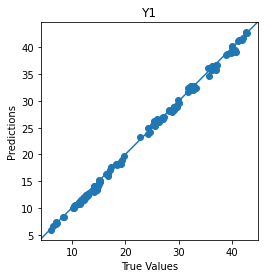

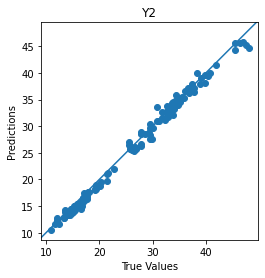

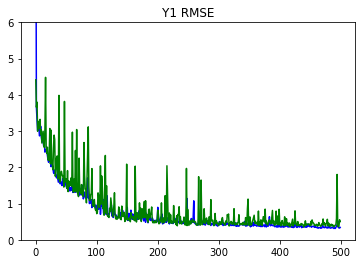

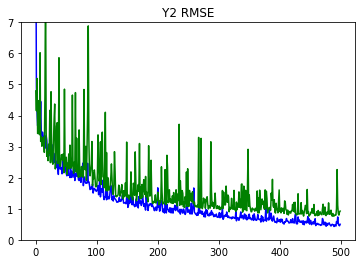

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)